In [1]:
import os
import sys
sys.path.append('../../../hetnet-ml/src')

import time
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import logit

import graph_tools as gt
from extractor import MatrixFormattedGraph
import plot_tools as pt

DATA_DIR = '../../data'

paper_figs = os.path.join(DATA_DIR, 'figures/paper_figs')
supp_figs = os.path.join(DATA_DIR, 'figures/supp_figs')
other_figs = os.path.join(DATA_DIR, 'figures/other_figs')

In [2]:
from scipy import interp                                                             
from sklearn.metrics import precision_recall_curve, roc_curve, auc        

In [3]:
def skip_ticks(tick_delta=2, angle=0):
    locs, labels = plt.xticks(rotation=angle)
    plt.xticks(locs[::tick_delta], labels[::tick_delta])

In [4]:
coefs = []
preds = {}

# set the parameters to get the right load directory
base_dir = os.path.join(DATA_DIR, 'time_networks-6_metanode')
max_indication_network_diff = 0
alpha = 0.1
scoring = 'recall'
negative_multiplier = 10
min_pmids = 2
gs_treat = False
w = 0.6
seed = 0

# Build the proper load Directory
test_params = os.path.join('alpha_{}'.format(alpha), 
                           '{}x_pos-neg'.format(negative_multiplier), 
                           '{}_year_diff'.format(max_indication_network_diff))
if scoring != 'roc_auc':
    test_params = os.path.join(test_params, '{}-scoring'.format(scoring))
if min_pmids > 1:
    test_params = os.path.join(test_params, '{}_pmids'.format(min_pmids))
if gs_treat:                                                                                                            
    test_params = os.path.join(test_params, 'gs_treats')
if w != 0.4:
    test_params = os.path.join(test_params, 'dwpc_w_{}'.format(w))
if seed != 0:
    test_params = os.path.join(test_params, 'seed_{}'.format(seed))

# Read in the data
years = list(range(1950, 2020, 1))


for year in years:
    out_dir = os.path.join(base_dir, str(year), test_params)
    
    # get the predictions for the year
    preds[year] = pd.read_csv(os.path.join(out_dir, 'predictions.csv'))

    # Read the model coefficients
    coef = pd.read_csv(os.path.join(out_dir, 'model_coefficients.csv'))

    # Only keep the actual model coefficients (rather than standardized...)
    coef = coef.set_index('feature').rename(columns={'coef': year})[year]
    coefs.append(coef)    
    
coefs = pd.concat(coefs, axis=1, sort=False).reset_index().rename(columns={'index': 'feature'})

In [5]:
coefs.head()

,feature,1950,1951,1952,1953,1954,1955,1956,1957,1958,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,intercept,-3.710436,-6.255288,-3.373837,-3.631038,-3.219541,-2.951198,-2.95718,-3.083935,-2.926731,...,-3.133360,-3.117908,-3.260664,-3.087051,-3.128331,-3.244940,-3.192978,-3.187867,-3.215049,-3.128906
1,degree_CDafA,-0.027489,0.353037,0.086673,0.258049,0.081801,0.000000,0.00000,0.000000,0.000000,...,0.037244,0.018996,0.051755,0.027087,0.018418,0.042935,0.039847,0.039999,0.053436,0.017709
2,degree_CDafPH,-0.209795,0.069097,0.000000,0.024582,0.013019,0.000000,0.00000,0.011156,0.000000,...,0.175791,0.204786,0.263378,0.194222,0.232172,0.252405,0.212619,0.258780,0.244132,0.193194
3,degree_CDagPS,0.000000,0.544520,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,degree_CDawPS,0.098826,0.119959,0.000000,-0.028918,0.000000,0.000000,0.00000,0.016831,0.000000,...,0.046645,0.066424,0.075731,0.058840,0.064950,0.066385,0.069990,0.045424,0.068859,0.075540


/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


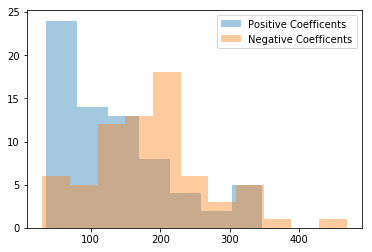

In [6]:
sns.distplot((coefs[years] > 0).sum(), kde=False, label='Positive Coefficents')
sns.distplot((coefs[years] < 0).sum(), kde=False, label='Negative Coefficents')
plt.legend();

#### Do some processing on the coefficitents

In [7]:
coefs = coefs.replace(0.0, np.nan)

# Count how many are selected each year
coefs['counts'] = coefs[years].T.count()

# How many positive?
coefs['n_pos'] = (coefs[years].T > 0).sum()

# Negative?
coefs['n_neg'] = (coefs[years].T < 0).sum()

# Mean for a coef over all years?
coefs['mean_val'] = coefs[years].T.mean()

# Median?
coefs['median_val'] = coefs[years].T.median()

# STD? 
coefs['std'] = coefs[years].T.std()

# Standarized mean?
coefs['mean_std'] = coefs['mean_val'] / coefs['std']

remainder = [c for c in coefs.columns if c not in years]

/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [8]:
melt_coef = coefs.melt(id_vars=remainder, value_vars=years)
melt_coef.head()

,feature,counts,n_pos,n_neg,mean_val,median_val,std,mean_std,variable,value
0,intercept,70,0,70,-3.110807,-3.079952,0.415026,-7.495446,1950,-3.710436
1,degree_CDafA,32,31,1,0.050392,0.039090,0.072073,0.699175,1950,-0.027489
2,degree_CDafPH,56,55,1,0.098791,0.087353,0.091918,1.074768,1950,-0.209795
3,degree_CDagPS,14,14,0,0.065602,0.025007,0.139126,0.471526,1950,NaN
4,degree_CDawPS,37,36,1,0.041977,0.039170,0.027826,1.508544,1950,0.098826


In [9]:
test_mps = (coefs.query('n_pos >= 5 and mean_std > .7 and mean_val > .1')
                 .sort_values('mean_val', ascending=False)['feature'][:5].values)

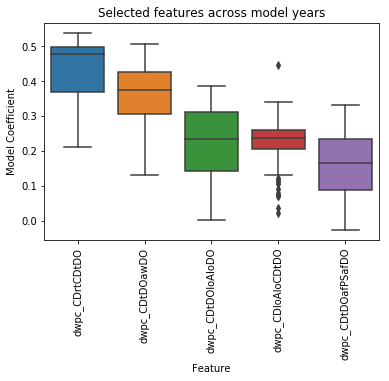

In [10]:
sns.boxplot(x='feature', y='value', data=melt_coef.query('feature in @test_mps').sort_values('mean_val', ascending=False))
plt.xlabel('Feature')
plt.ylabel('Model Coefficient')
plt.title('Selected features across model years')
plt.xticks(rotation=90);

In [11]:
order = coefs.fillna(0)[years].mean(axis=1).sort_values(ascending=False).index
top_mps = coefs.loc[order, 'feature'].values[:10]

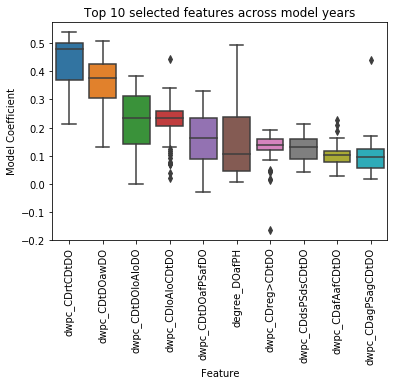

In [12]:
sns.boxplot(x='feature', y='value', data=melt_coef.query('feature in @top_mps').sort_values('mean_val', ascending=False))
plt.xlabel('Feature')
plt.ylabel('Model Coefficient')
plt.title('Top 10 selected features across model years')
plt.xticks(rotation=90)
plt.savefig(os.path.join(paper_figs, '3B.svg'), bbox_inches='tight', pad_inches=0.1);

### See if we can standardize the coefficients across model years.... 

Becasue the min and max coefficient in each model may be different values, 
Standardizing each year by min and max will show how much these really differ between years

In [13]:
year_max_coef = melt_coef.groupby('variable')['value'].max()
year_max_coef[1950]

0.3289134995651002

In [14]:
melt_coef['rel_value'] = melt_coef.apply(lambda row: row['value'] / year_max_coef[row['variable']], axis=1)

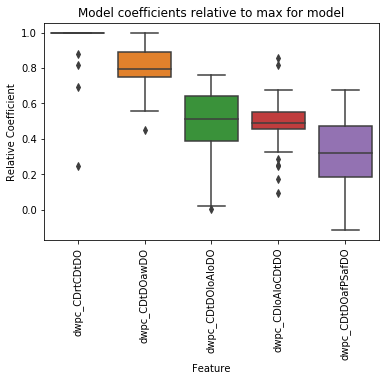

In [15]:
sns.boxplot(x='feature', y='rel_value', data=melt_coef.query('feature in @test_mps').sort_values('mean_val', ascending=False))
plt.xlabel('Feature')
plt.ylabel('Relative Coefficient')
plt.title('Model coefficients relative to max for model')
plt.xticks(rotation=90);

In [16]:
top_rels = melt_coef.fillna(0).groupby('feature')['rel_value'].mean().sort_values(ascending=False).index[:10]

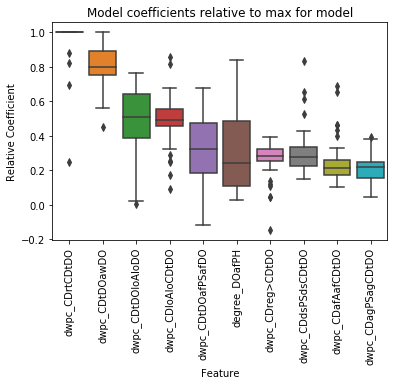

In [17]:
sns.boxplot(x='feature', y='rel_value', data=melt_coef.query('feature in @top_rels').sort_values('mean_val', ascending=False))
plt.xlabel('Feature')
plt.ylabel('Relative Coefficient')
plt.title('Model coefficients relative to max for model')
plt.xticks(rotation=90);

In [18]:
coef_info = pd.melt(coefs.fillna(0.0), id_vars=['feature'], value_vars=years)
coef_info = coef_info.rename(columns={'variable': 'network_year'})
coef_info.head(2)

,feature,network_year,value
0,intercept,1950,-3.710436
1,degree_CDafA,1950,-0.027489


In [19]:
coef_counts = []
for year, df in coef_info.groupby('network_year'):
    n_pos = (df['value'] > 0).sum()
    n_neg = (df['value'] < 0).sum()
    coef_counts.append(pd.DataFrame({'network_year': [year]*2, 'num': [n_pos, n_neg], 
                                     'Coefficient Sign': ['Postivie', 'Negative']}))
coef_counts = pd.concat(coef_counts)

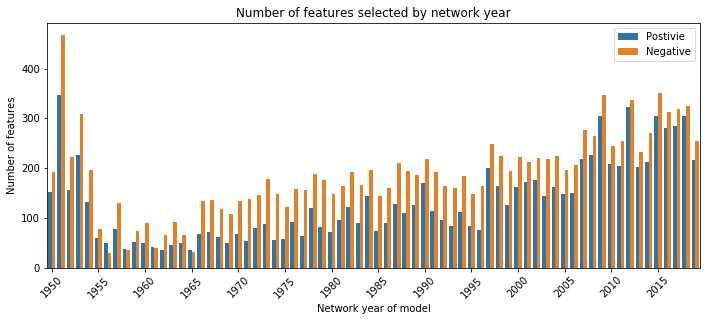

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 4.5)
sns.barplot(x='network_year', y='num', data=coef_counts, hue='Coefficient Sign', ax=ax)

plt.title('Number of features selected by network year')
plt.xlabel('Network year of model')
plt.ylabel('Number of features')
plt.legend(title='')

tick_delta = 5
locs, labels = plt.xticks(rotation=45)
plt.xticks(locs[::tick_delta], labels[::tick_delta])
plt.savefig(os.path.join(supp_figs, 'S2.svg'), bbox_inches='tight', pad_inches=0.1);

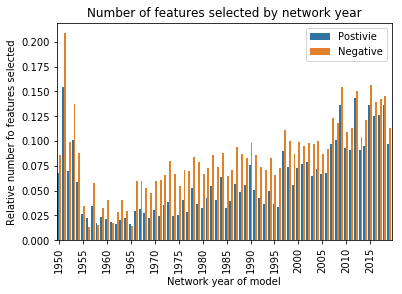

In [21]:
max_features = len(coefs)
coef_counts['rel_features'] = coef_counts['num'] / max_features

sns.barplot(x='network_year', y='rel_features', data=coef_counts, hue='Coefficient Sign')

plt.title('Number of features selected by network year')
plt.xlabel('Network year of model')
plt.ylabel('Relative number fo features selected')
plt.legend(title='')

tick_delta = 5
locs, labels = plt.xticks(rotation=90)
plt.xticks(locs[::tick_delta], labels[::tick_delta]);

## ROC Results

/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


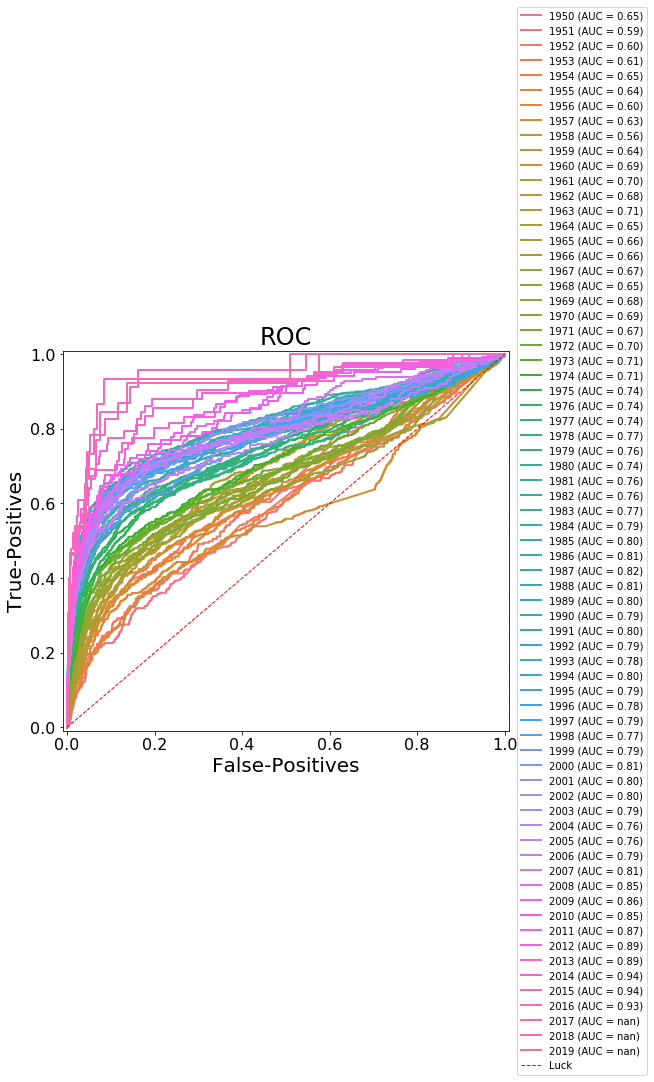

In [22]:
ys = []
y_preds = []

with sns.color_palette('husl', n_colors=len(preds)):
    for year in years:
        y_true = preds[year].dropna(subset=['test_probas'])['status']
        y_pred = preds[year].dropna(subset=['test_probas'])['test_probas']
        ys.append(y_true)
        y_preds.append(y_pred)
        pt.graph_single_roc(y_true, y_pred, label=str(year), lw=2)
    #pt.graph_mean_roc(ys, y_preds)
    pt.graph_roc_boilerplate('ROC')
    plt.legend(loc='right', bbox_to_anchor=(1.32,.5));

/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/sklearn/metrics/ranking.py:415: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


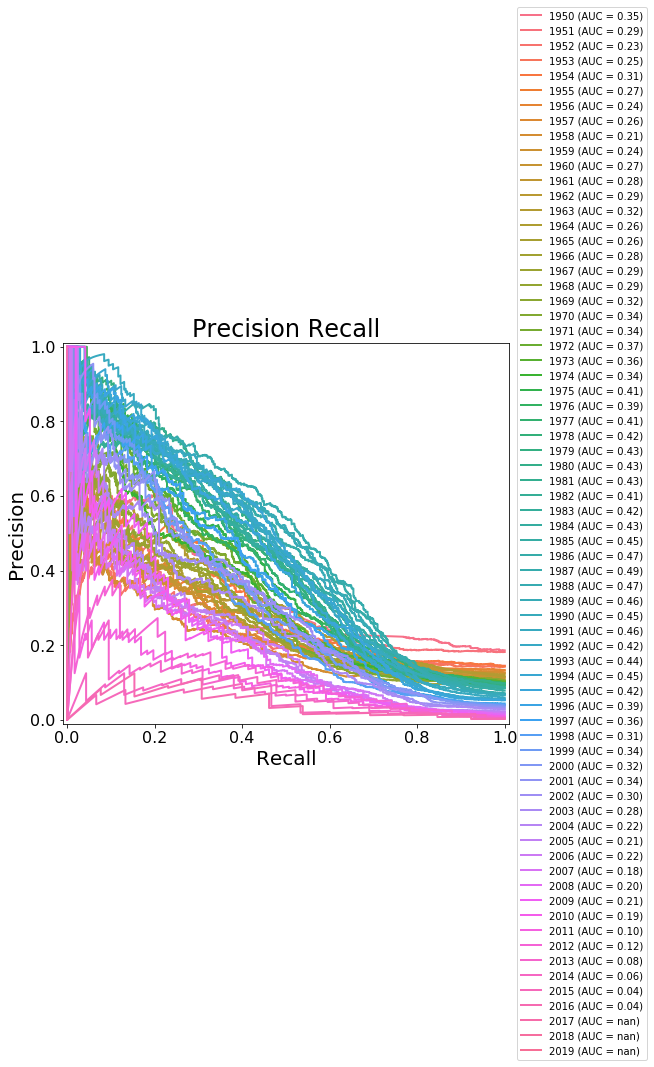

In [23]:
ys = []
y_preds = []

with sns.color_palette('husl', n_colors=len(preds)):


    for year in years:
        y_true = preds[year].dropna(subset=['test_probas'])['status']
        y_pred = preds[year].dropna(subset=['test_probas'])['test_probas']

        ys.append(y_true)
        y_preds.append(y_pred)

        pt.graph_single_prc(y_true, y_pred, label=str(year), lw=2)
    #pt.graph_mean_prc(ys, y_preds)
    pt.graph_prc_boilerplate('Precision Recall')
    plt.legend(loc='right', bbox_to_anchor=(1.32,.5));

In [24]:
from scipy import interp                                                             
from sklearn.metrics import precision_recall_curve, roc_curve, auc        

def calc_roc(df):
    fpr, tpr, thresholds = roc_curve(df['status'], df['all_probas'])                                  
    roc_auc = auc(fpr, tpr)                                                      
    return roc_auc
    
def calc_prc(df):
    pre, rec, thresholds = precision_recall_curve(df['status'], df['all_probas'])                                  
    roc_prc = auc(rec, pre)                                                      
    return roc_prc

In [25]:
from collections import defaultdict

In [26]:
roc_result = defaultdict(list)

for year in years:
    frame = preds[year].query('dataset == "test"')
    
    # Calc ROC and PRC
    roc = calc_roc(frame)
    prc = calc_prc(frame)
    
    # Add ROC to data frame
    roc_result['network_year'].append(year)
    roc_result['metric'].append(roc)
    roc_result['metric_name'].append('AUROC')
    
    # Add PRC to data frame
    roc_result['network_year'].append(year)
    roc_result['metric'].append(prc)
    roc_result['metric_name'].append('AUPRC')


roc_result = pd.DataFrame(roc_result).sort_values(['metric_name', 'network_year'], ascending=False)
roc_result.query('network_year in {}'.format(list(range(1950, 2020, 5))))

/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/sklearn/metrics/ranking.py:415: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


,metric,metric_name,network_year
130,0.935297,AUROC,2015
120,0.847102,AUROC,2010
110,0.763900,AUROC,2005
100,0.805919,AUROC,2000
90,0.787091,AUROC,1995
80,0.791153,AUROC,1990
70,0.798055,AUROC,1985
60,0.736334,AUROC,1980
50,0.744433,AUROC,1975
40,0.687754,AUROC,1970


In [27]:
roc_result.query('network_year == 1985')

,metric,metric_name,network_year
70,0.798055,AUROC,1985
71,0.447597,AUPRC,1985


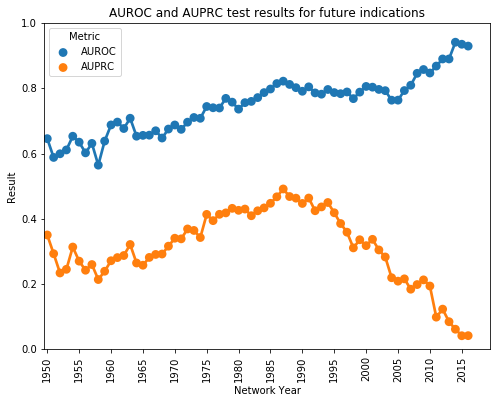

In [28]:
plt.figure(figsize=(8,6))
sns.pointplot(x='network_year', y='metric', hue='metric_name', data=roc_result)

plt.title('AUROC and AUPRC test results for future indications')
plt.xlabel('Network Year')
plt.ylabel('Result')
plt.ylim([0, 1])
plt.legend(title='Metric', loc=2)

tick_delta = 5
locs, labels = plt.xticks(rotation=90)
plt.xticks(locs[::tick_delta], labels[::tick_delta])
plt.savefig(os.path.join(paper_figs, '3A.svg'), bbox_inches='tight', pad_inches=0.1);

In [29]:
year_training_info = []
for year in years:

    test_true = preds[year].dropna(subset=['test_probas'])['status'].sum()
    all_true = preds[year]['status'].sum()
    train_true = all_true - test_true

    year_training_info.append({'train_true': train_true,
                               'test_true': test_true, 
                               'all_true': all_true,
                               'year': year})
train_info = pd.DataFrame(year_training_info)

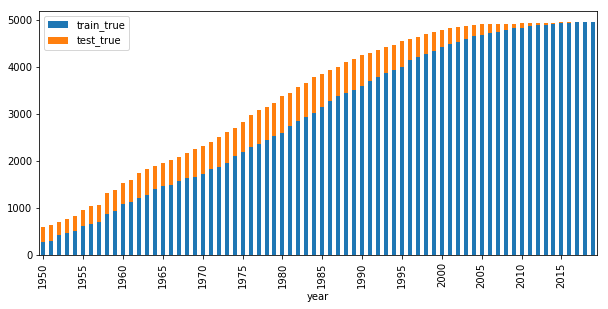

In [30]:
train_info.set_index('year')[['train_true', 'test_true']].plot(kind='bar', stacked=True, figsize=(10,4.5))
tick_delta = 5
locs, labels = plt.xticks(rotation=90)
plt.xticks(locs[::tick_delta], labels[::tick_delta]);